# Generate text based features

In [1]:
import pandas as pd
import numpy as np
import textstat
import matplotlib.pyplot as plt
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage/kaggle_output/commonlitreadabilityprize")

In [2]:
df = pd.read_csv(OUTPUT_PATH / "20210607-205257" / "oofs_0.49327.csv")

df["residual"] = df["prediction"] - df["target"]
df.head()

,id,url_legal,license,excerpt,target,standard_error,fold,prediction,residual
0,6fceedb16,https://www.digitallibrary.io/en/books/details...,CC BY 4.0,It's carnival day. Hooray! shouts Little Mouse...,0.478452,0.553224,2,0.509785,0.031333
1,6a548181f,NaN,NaN,M. Leclerc du Sablon has published some of his...,-2.742465,0.503407,1,-2.561467,0.180999
2,3c0447a11,NaN,NaN,The cowherds loosened the buffalo's halter and...,-1.835394,0.505738,4,-0.585046,1.250348
3,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166,2,-0.907744,0.633603
4,a83725b19,NaN,NaN,I know that many people are worrying about Sta...,-1.191174,0.475461,0,-1.073316,0.117858


In [3]:
text = df.loc[0, "excerpt"]
print(text)

It's carnival day. Hooray! shouts Little Mouse. Hooray! shouts Littler Mouse. Hooray! shouts Tiny Mouse.
They plan to ride every ride!
"But don't lose me!" Tiny Mouse tells his brothers.
They race each other on toy cars. They go up and down on the merry-go-round. They ride the winding caterpillar coaster. They take a spin on the Ferris wheel.The brothers walk to the balloon cart and they each buy a balloon.
One balloon, two balloons...
"Wait, where is Tiny Mouse? "
Little Mouse and Littler Mouse run to the toy cars.
Tiny Mouse isn't there.
They run to the merry-go-round.
Tiny Mouse isn't there.
They run to the caterpillar coaster.
Tiny Mouse isn't there, either.
They run to the Ferris wheel.
Thank goodness!
The Little Mice each buy a glass of sugarcane juice. One glass, two glasses, three glasses!


In [10]:
def generate_features(text):
    return {
        "sentence_count": textstat.sentence_count(text),
        "lexicon_count": textstat.lexicon_count(text),
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
#         "smog_index": textstat.smog_index(text),
#         "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
    }


features_df = pd.DataFrame([generate_features(text) for text in df["excerpt"]])
features_df.head()

,sentence_count,lexicon_count,flesch_reading_ease
0,19,138,97.91
1,10,180,61.67
2,6,188,73.55
3,5,170,70.81
4,6,166,51.82


In [11]:
features_df.describe()

,sentence_count,lexicon_count,flesch_reading_ease
count,2834.000000,2834.000000,2834.000000
mean,8.564220,172.948483,67.742121
std,3.666797,16.974894,17.530230
min,2.000000,135.000000,-22.930000
25%,6.000000,159.000000,57.510000
50%,8.000000,175.000000,69.010000
75%,10.000000,187.000000,80.110000
max,38.000000,205.000000,114.520000


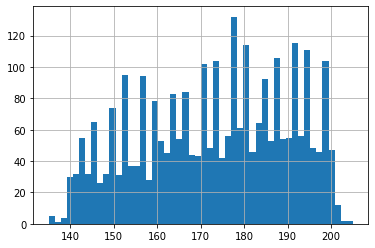

In [5]:
features_df["lexicon_count"].hist(bins=50);

# Test using `LinearRegression` and other models

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [7]:
def create_dataset(path):
    df = pd.read_csv(path)
    features_df = pd.DataFrame([generate_features(text) for text in df["excerpt"]])
    df = df.join(features_df)
    features = ["prediction"] + features_df.columns.tolist()
    return df, features


def evaluate_model(model, df, features):
    scores = []

    for fold in range(5):
        train = df.query(f"fold != {fold}")
        valid = df.query(f"fold == {fold}")
        X_train, y_train = train[features], train["target"]
        X_valid, y_valid = valid[features], valid["target"]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        scores.append(rmse)
        print(f"Fold {fold} RMSE: {rmse:0.5f}", model.coef_, model.intercept_)

    final_rmse = np.mean(scores)
    print(f"Final RMSE: {final_rmse:0.5f}")
    return final_rmse

In [8]:
paths = [
    OUTPUT_PATH / "20210607-205257" / "oofs_0.49327.csv",
    OUTPUT_PATH / "20210607-222744" / "oofs_0.50062.csv",    
    OUTPUT_PATH / "20210607-234728" / "oofs_0.49806.csv",
]

In [9]:
scores = []

for path in paths:
    scores.append(evaluate_model(LinearRegression(), *create_dataset(path)))
    
np.mean(scores)

Fold 0 RMSE: 0.49622 [ 9.59936974e-01 -8.35115865e-04  5.45502108e-04] -0.004779903983524791
Fold 1 RMSE: 0.48444 [ 9.56879493e-01 -3.37367657e-04  4.14121608e-04] -0.06542154811528256
Fold 2 RMSE: 0.48922 [ 9.55914119e-01 -1.24551630e-03  3.10951493e-04] 0.07520703945619356
Fold 3 RMSE: 0.47394 [ 9.59124631e-01 -7.95555618e-04  8.75866082e-04] -0.028166961511662425
Fold 4 RMSE: 0.49636 [ 9.73665321e-01 -6.17760624e-04 -1.63606411e-04] 0.023852314127885132
Final RMSE: 0.48804
Fold 0 RMSE: 0.49206 [ 9.90452295e-01 -2.23907640e-03 -7.23960773e-04] 0.36413679651547004
Fold 1 RMSE: 0.47331 [ 9.84949067e-01 -1.26684938e-03 -4.87026624e-04] 0.16413249797771012
Fold 2 RMSE: 0.51218 [ 0.98589651 -0.00238271 -0.0014135 ] 0.41637658412867673
Fold 3 RMSE: 0.50036 [ 1.01846461 -0.00109244 -0.00111165] 0.20700815500680303
Fold 4 RMSE: 0.50402 [ 9.95014686e-01 -1.14114582e-03 -1.79413710e-04] 0.12057344921155577
Final RMSE: 0.49639
Fold 0 RMSE: 0.48326 [ 9.71055856e-01 -1.54210492e-03 -1.40406192e-0

0.49510409817970347